In [1]:
#from architecture import *
import torch
from data import get_dataloader
from utils import create_sampler
import numpy as np
import random

from functions import *
from PT_plus_MAP import *

In [2]:
# Download the dataset.
# Execute the notebooks in dataset to download the data and prepare them.

In [3]:
### Architecture ###
# model = MLP(num_layers=2, num_feat=512, num_classes=61)
# model = Conv1d(num_layers=2, num_feat=512, num_classes=61)
# model = GNN(num_classes=61)

# Only the needed variables will be used to create the model.
model_name = 'GNN'  #'MLP', 'GNN' or 'Conv1d'
num_classes = 61  # Number of classes in the base dataset. 
num_layers = 1  # Number of hidden layers.
num_feat = 360  # For 'MLP'/'GNN', number of features per hidden layer. For 'Conv1d', number of feature maps per hidden layer.
n_step = 1  # Only for 'GNN'. Number of times the input signal is diffused. See the 'GNN' architecture for more details.
inplanes = 8

### Optimization ###
lr = 0.1
weight_decay = 1e-4
lr_gamma = 0.1
n_epoch = 90

In [4]:
# Architecture
model_parameters = get_model_parameters(model_name, num_layers, num_feat, num_classes, n_step)
model = get_model(model_name, model_parameters)

# Data parameters
### TO UPDATE
IBC_path = '/home/brain/nilearn_data/neurovault/collection_6618/'
split_dir = '../dataset/split/'
parcel, batch_size = get_variables(model.name)

# Episodes parameters
n_episode = 500
n_way = 5
n_shot = 1
n_query = 15

# Save path
save_path = f'./results/{model.name}/'

# Sampler
train_sampler = create_sampler(IBC_path, split_dir, 'train')
val_sampler_infos = [n_episode, n_way, n_shot, n_query]

# Loader
train_loader = get_dataloader('train', IBC_path, parcel, split_dir, meta=False, batch_size=batch_size, sampler=train_sampler)
val_loader = get_dataloader('val', IBC_path, parcel, split_dir, meta=True, sampler_infos=val_sampler_infos)

# Train the model

In [5]:
# Optimization
criterion = nn.CrossEntropyLoss()
optimizer, scheduler = get_optimizer(model, lr, n_epoch)

# Move on CUDA.
use_cuda = True
model = model.cuda()
    
# Number of epochs between each evaluation on the validation dataset.
iter_val_acc = 5

In [6]:
# Train the model and evaluate it on the validation set at each epoch.
epochs_acc = []
epochs_loss = []
epochs_train_acc = []

best_acc = -1
for epoch in range(n_epoch+1):
    # Train for one epoch.
    epoch_loss, epoch_train_acc = train(model, criterion, optimizer, train_loader, use_cuda)
    print("\rLoss at epoch {}: {:.2f}.".format(epoch+1, epoch_loss), end='')
    print("(Acc \t: {:.2f}).".format(epoch_train_acc*100),end='')
    # Evaluate on the few-shot tasks from the validation set.
    if epoch % iter_val_acc == 0:
        optimizer.zero_grad()
        epoch_acc = episodic_evaluation(model, val_loader, val_sampler_infos, use_cuda)
        print("Acc on tasks at epoch {}: {:.2f}.".format(epoch+1, epoch_acc*100))
    scheduler.step()
    # Check if it is the best epoch_acc so far.
    is_best = epoch_acc > best_acc
    best_acc = max(epoch_acc, best_acc)
    
    # Save the model
    epochs_loss.append(epoch_loss)
    epochs_train_acc.append(epoch_train_acc*100)
    epochs_acc.append(epoch_acc*100)
    save_checkpoint({
                'epoch': epoch + 1,
                'arch': "MLP - num_layers {} - num_feat {} - num_classes {}".format(num_layers, num_feat, num_classes),
                'state_dict': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
                'epochs_acc': epochs_acc,
                'epochs_train_acc': epochs_train_acc,
                'epochs_loss': epochs_loss 
            }, is_best, folder=save_path)


  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 1: 3.85.(Acc 	: 6.21).

100%|██████████| 500/500 [00:07<00:00, 64.80it/s]

Acc on tasks at epoch 1: 47.15.


Loss at epoch 5: 1.40.(Acc 	: 56.82).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 6: 1.16.(Acc 	: 65.54).

100%|██████████| 500/500 [00:07<00:00, 65.05it/s]

Acc on tasks at epoch 6: 57.24.


Loss at epoch 10: 0.71.(Acc 	: 77.56).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 11: 0.58.(Acc 	: 82.81).

100%|██████████| 500/500 [00:07<00:00, 64.50it/s]

Acc on tasks at epoch 11: 60.45.


Loss at epoch 15: 0.38.(Acc 	: 88.86).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 16: 0.34.(Acc 	: 88.22).

100%|██████████| 500/500 [00:07<00:00, 64.42it/s]

Acc on tasks at epoch 16: 59.74.


Loss at epoch 20: 0.29.(Acc 	: 90.07).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 21: 0.26.(Acc 	: 92.82).

100%|██████████| 500/500 [00:07<00:00, 64.28it/s]

Acc on tasks at epoch 21: 61.49.


Loss at epoch 25: 0.17.(Acc 	: 94.92).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 26: 0.20.(Acc 	: 93.79).

100%|██████████| 500/500 [00:07<00:00, 64.46it/s]

Acc on tasks at epoch 26: 59.30.


Loss at epoch 30: 0.15.(Acc 	: 95.88).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 31: 0.13.(Acc 	: 95.48).

100%|██████████| 500/500 [00:07<00:00, 64.41it/s]

Acc on tasks at epoch 31: 59.09.


Loss at epoch 35: 0.13.(Acc 	: 96.37).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 36: 0.13.(Acc 	: 95.88).

100%|██████████| 500/500 [00:07<00:00, 64.10it/s]

Acc on tasks at epoch 36: 59.16.


Loss at epoch 40: 0.13.(Acc 	: 96.21).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 41: 0.11.(Acc 	: 97.09).

100%|██████████| 500/500 [00:07<00:00, 64.53it/s]

Acc on tasks at epoch 41: 60.01.


Loss at epoch 45: 0.10.(Acc 	: 97.42).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 46: 0.08.(Acc 	: 97.90).

100%|██████████| 500/500 [00:07<00:00, 64.23it/s]

Acc on tasks at epoch 46: 58.55.


Loss at epoch 50: 0.05.(Acc 	: 99.19).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 51: 0.05.(Acc 	: 99.52).

100%|██████████| 500/500 [00:07<00:00, 64.44it/s]

Acc on tasks at epoch 51: 60.03.


Loss at epoch 55: 0.05.(Acc 	: 99.19).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 56: 0.05.(Acc 	: 99.35).

100%|██████████| 500/500 [00:07<00:00, 67.55it/s]

Acc on tasks at epoch 56: 58.94.


Loss at epoch 60: 0.04.(Acc 	: 99.68).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 61: 0.05.(Acc 	: 99.52).

100%|██████████| 500/500 [00:07<00:00, 64.01it/s]

Acc on tasks at epoch 61: 59.37.


Loss at epoch 65: 0.05.(Acc 	: 99.27).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 66: 0.05.(Acc 	: 99.35).

100%|██████████| 500/500 [00:07<00:00, 66.76it/s]

Acc on tasks at epoch 66: 59.36.


Loss at epoch 70: 0.05.(Acc 	: 99.27).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 71: 0.05.(Acc 	: 99.19).

100%|██████████| 500/500 [00:07<00:00, 69.17it/s]

Acc on tasks at epoch 71: 58.94.


Loss at epoch 75: 0.05.(Acc 	: 99.11).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 76: 0.05.(Acc 	: 99.27).

100%|██████████| 500/500 [00:07<00:00, 64.76it/s]

Acc on tasks at epoch 76: 59.10.


Loss at epoch 80: 0.04.(Acc 	: 99.27).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 81: 0.04.(Acc 	: 99.44).

100%|██████████| 500/500 [00:07<00:00, 64.30it/s]

Acc on tasks at epoch 81: 59.94.


Loss at epoch 85: 0.04.(Acc 	: 99.35).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 86: 0.04.(Acc 	: 99.52).

100%|██████████| 500/500 [00:07<00:00, 62.99it/s]


Acc on tasks at epoch 86: 59.29.
Loss at epoch 90: 0.04.(Acc 	: 99.60).

  0%|          | 0/500 [00:00<?, ?it/s]

Loss at epoch 91: 0.04.(Acc 	: 99.27).

100%|██████████| 500/500 [00:07<00:00, 63.53it/s]

Acc on tasks at epoch 91: 58.86.


In [7]:
# Check the training has been correct.
def load_statistics(save_path, type='last'):
    if type == 'best':
        checkpoint = torch.load('{}/model_best.pth.tar'.format(save_path))
    elif type == 'last':
        checkpoint = torch.load('{}/checkpoint.pth.tar'.format(save_path))
    else:
        assert False, 'type should be in [best, or last], but got {}'.format(type)
    epochs_acc = checkpoint['epochs_acc']
    epochs_train_acc = checkpoint['epochs_train_acc']
    epochs_loss = checkpoint['epochs_loss']
    best_acc = checkpoint['best_acc']
    return epochs_acc, epochs_loss, epochs_train_acc, best_acc

epochs_acc, epochs_loss, epochs_train_acc, best_acc = load_statistics(save_path)

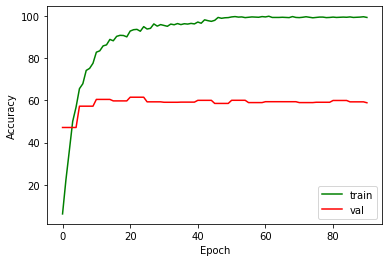

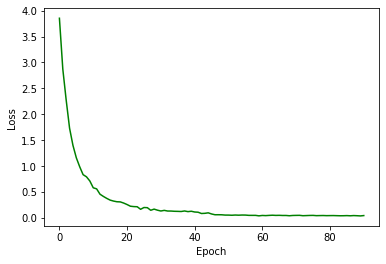

The best accuracy on tasks on the validation set is: 61.49.


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(epochs_train_acc, 'g', label='train')
plt.plot(epochs_acc, 'r', label='val')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
plt.plot(epochs_loss, 'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

print("The best accuracy on tasks on the validation set is: {:.2f}.".format(best_acc*100))

# Test the model

In [9]:
# Loader
train_loader = get_dataloader('train', IBC_path, parcel, split_dir, meta=False, batch_size=1, sampler=None)
test_loader = get_dataloader('test', IBC_path, parcel, split_dir, meta=False, batch_size=1, sampler=None)

In [10]:
acc_1_shot,conf1, acc_5_shot, conf5 = do_extract_and_evaluate_simplified(model, train_loader, test_loader, save_path)
acc_1_shot, conf1, acc_5_shot, conf5

(0.600348, 0.002109496179907163, 0.7529880000000001, 0.0017677327145184415)

In [11]:
test_loader = get_dataloader('test', IBC_path, parcel, split_dir, meta=False, batch_size=1, sampler=None)
acc_1_shot, conf1, acc_5_shot, conf5 = do_extract_and_evaluate_simplified_PT_plus_MAP(model, test_loader, save_path)

In [12]:
acc_1_shot, conf1, acc_5_shot, conf5

(0.6705320006780326,
 0.0029499481925461374,
 0.7652946676820517,
 0.0020002435670376166)